# Generate CMA using tick data service - Python

### Overview
Moving averages smooth the price movements by filtering out the "noise" caused by short-term price fluctuations.They also form the building blocks for a wide range of technical indicators.

Computing moving averages over a defined number of time periods is useful to:
* identify the trend direction
* determine support and resistance levels

This sample demonstrates how to request and plot **on-demand** *cumulative moving average - CMA* from a tick data service.

### Inputs/outputs
Cumulative moving averages' requests require instrument's identifier, date time intervals and number of periods as per inputs.

CMA is the average of all the data points.

This sample shows how to plot a simple graph for basis technical analysis using an open source library. 

### Services used
This sample uses *gRPC requests* in order to retrieve tick data from the hosted service. The queried endpoint in this script are:
* *TickCmaService *: to directly retrieve tick cma data from the server

### Modules required
1. Systemathics:
    * *systemathics.apis.services.tick_analytics.v1*
    * *systemathics.apis.type.shared.v1*
    * *google.type*
2. Open source:
    * *googleapis-common-protos*
    * *protobuf*
    * *grpcio*
    * *pandas*
    * *plotly* and *matplotlib* as per display packages

***

# Run CMA sample

### Step 1: Install packages

In [1]:
pip install googleapis-common-protos protobuf grpcio pandas plotly matplotlib

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install systemathics.apis --pre

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import grpc
import pandas as pd
from datetime import datetime
from datetime import timedelta
import google.type.date_pb2 as date
import google.type.timeofday_pb2 as timeofday
import google.type.dayofweek_pb2 as dayofweek
import google.protobuf.duration_pb2 as duration
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.type.shared.v1.constraints_pb2 as constraints
import systemathics.apis.type.shared.v1.date_interval_pb2 as dateinterval
import systemathics.apis.type.shared.v1.time_interval_pb2 as timeinterval
import systemathics.apis.services.tick_analytics.v1.tick_cma_pb2 as tick_cma
import systemathics.apis.services.tick_analytics.v1.tick_cma_pb2_grpc as tick_cma_service
import systemathics.apis.helpers.token_helpers as token_helpers
import systemathics.apis.helpers.channel_helpers as channel_helpers

### Step 2: Retrieve authentication token
The following code snippet sends authentication request and print token to console output in order to process the upcomming *gRPC queries*.

In [4]:
token = token_helpers.get_token()


### Step 3: Create and process request
To request *CMA* service, we need to specify:
* Instrument identifier
* Time period selection: select start and end dates
* Cumulative moving average request parameters

#### 3.1 Instrument selection

In [5]:
# set instrument identifier: exchange + ticker
ticker = 'AAPL'
exchange = 'BATS'

#### 3.2 CMA parameters

In [6]:
field = tick_cma.CMA_PRICE_TRADE; # set the SMA calculation field
sampling = 1 * 60

#### 3.3 Time period delimitation

In [7]:
# create time intervals (we are using Google date format)
date_interval = dateinterval.DateInterval(
    start_date = date.Date(year = 2021, month = 11, day = 18), 
    end_date = date.Date(year = 2021, month =11, day = 18)
)

# build the market data request time interval (we are using Google time format)
# UTC time zone
time_interval = timeinterval.TimeInterval(
    start_time = timeofday.TimeOfDay(hours = 8, minutes = 0, seconds = 0), 
    end_time = timeofday.TimeOfDay(hours = 20, minutes = 0, seconds = 0)
)

In [8]:
# generate constraints based on the previous time selection
my_constraints = constraints.Constraints(
    date_intervals = [date_interval],
    time_intervals = [time_interval],
)

#### 3.4 CMA request creation
The following code snippets creates *gRPC client*, process *CMA* request and returns the request reply:

In [9]:
# generate the tick long CMA request
long_request = tick_cma.TickCmaRequest(
    identifier = identifier.Identifier(exchange = exchange, ticker = ticker),
    constraints = my_constraints,
    field = field,
    sampling = duration.Duration(seconds = sampling)
)

In [10]:
try:
    # open a gRPC channel
    with channel_helpers.get_grpc_channel() as channel:  
        
        # instantiate the tick CMA service
        service = tick_cma_service.TickCmaServiceStub(channel)
        
        averages, prices, time_stamps = [], [], []
        # process the tick CMA request
        for c in service.TickCma(request = long_request, metadata = [('authorization', token)]):
            time_stamps.append(c.time_stamp)
            prices.append(c.value)
            averages.append(c.average.value)
except grpc.RpcError as e:
    display(e.code().name)
    display(e.details())

The following code snippet displays the total retrieved CMA data points count:

In [11]:
print('Total CMA data points retrived: {0}'.format(len(averages)))

Total CMA data points retrived: 480


### Step 4: Visualize data

#### 4.1 Retrieve CMA data

In [12]:
# create the SMAs dataframe
dates=[datetime.fromtimestamp(ts.seconds) for ts in time_stamps]
d = {'Date': dates, 'Cma': averages, 'Price': prices}
df = pd.DataFrame(data=d)
df

,Date,Cma,Price
0,2021-11-18 13:01:57,153.930000,153.93
1,2021-11-18 13:02:04,153.935000,153.94
2,2021-11-18 13:03:34,153.926667,153.91
3,2021-11-18 13:05:57,153.920000,153.90
4,2021-11-18 13:05:57,153.916000,153.90
...,...,...,...
475,2021-11-18 20:56:00,155.165609,157.54
476,2021-11-18 20:57:03,155.170860,157.67
477,2021-11-18 20:58:01,155.176423,157.83
478,2021-11-18 20:59:01,155.181816,157.76


#### 4.2 Plot tick CMA and prices with matplotlib

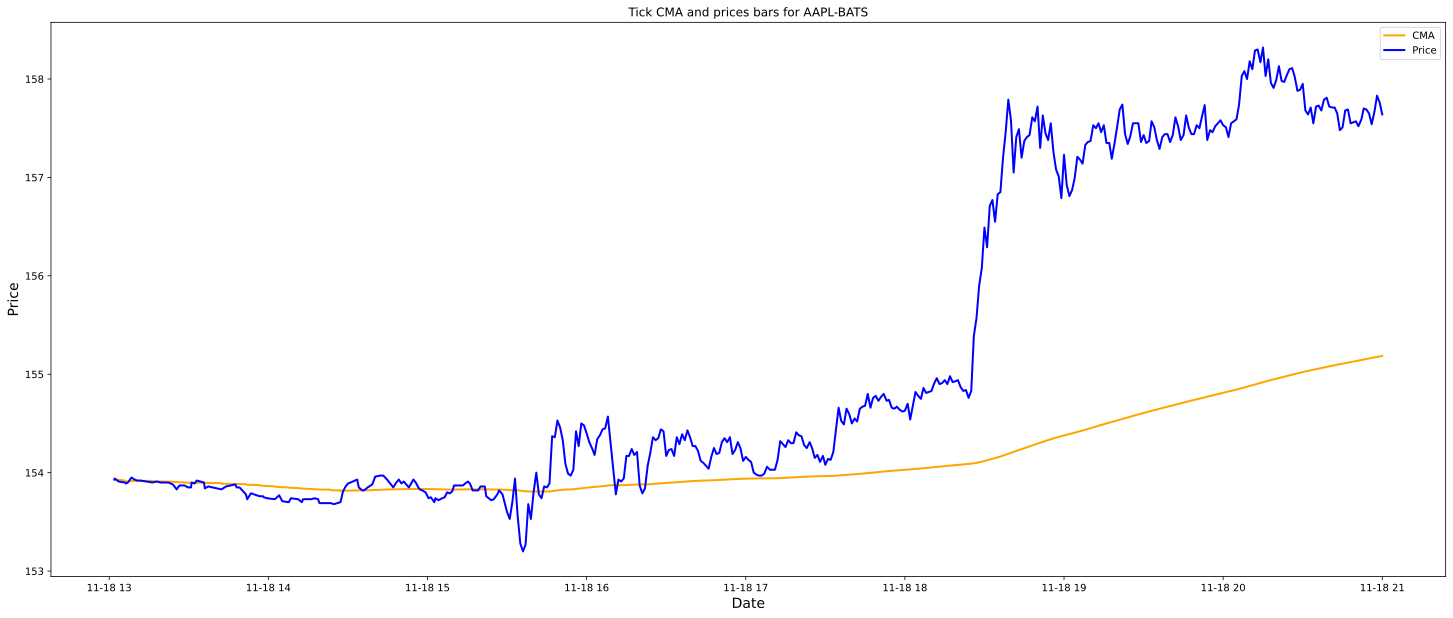

In [13]:
from matplotlib_inline import backend_inline as mplbi1
mplbi1.set_matplotlib_formats('svg')

import matplotlib.pyplot as plt

# create figure and axis objects with subplots()
fig,ax = plt.subplots(1,1,figsize=(25,10))
ax.plot('Date', 'Cma', data=df, marker='', color='orange', linewidth=2, label="CMA")
ax.plot('Date', 'Price', data=df, marker='', color='blue', linewidth=2, label="Price")

ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Price",color="black",fontsize=14)
plt.legend()
plt.title('Tick CMA and prices bars for {0}-{1}'.format(ticker,exchange))
plt.show()

#### 4.3 Plot tick CMA and prices with plotly

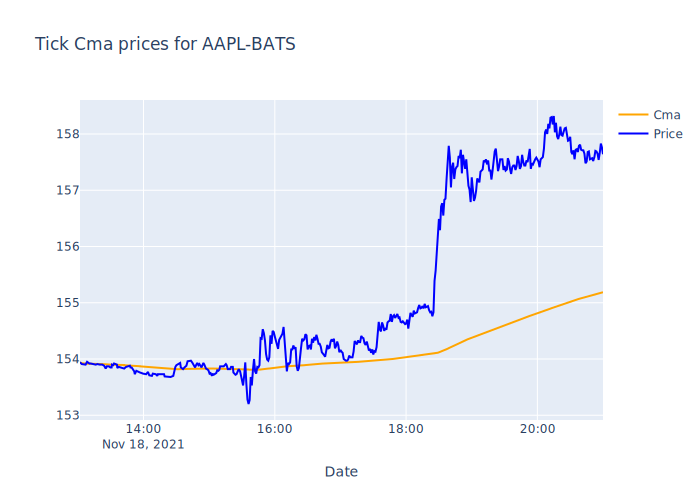

In [14]:
import plotly.io as pio2
pio2.renderers.default = 'svg'

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Cma'], name='Cma', marker_color ='orange'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Price'], name='Price', marker_color ='blue'))
fig.update_xaxes(title_text = 'Date')
fig.update_layout(title = 'Tick Cma prices for {0}-{1}'.format(ticker,exchange))
fig.show()